# Synthetic Data with interaction: recovery of relevant features

## SE2

### Data

In [1]:
from pyselect.data import jordan_se2
from ignite.utils import manual_seed

In [2]:
manual_seed(2000)
X_se2, y_se2 = jordan_se2(rho=0.5)

Visualization

In [3]:
import matplotlib.pyplot as plt
plt.style.use("../figures/pyselect.mplstyle")

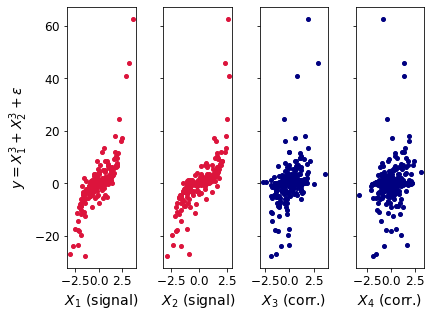

In [4]:
fig, ax = plt.subplots(ncols=4, sharey=True)
ax[0].plot(X_se2[:, 0], y_se2, 'o', markersize=4, color='crimson')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1^3 + X_2^3 + \epsilon$")
ax[1].plot(X_se2[:, 1], y_se2, 'o', markersize=4, color='crimson')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 4):
    ax[i].plot(X_se2[:, i], y_se2, 'o', markersize=4, color='navy')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.subplots_adjust(wspace=0.4)
plt.show()

## Model

In [5]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.data import train_val_test_split
from pyselect.train import ridge_loss, score_function, best_model_callback

Set train, validation and test sizes

In [6]:
train_size = 300
val_size = 150
test_size = 150

Generate date with $\rho = 0.5$

In [7]:
n_features = 10 

In [8]:
manual_seed(0)
X_se2, y_se2 = jordan_se2(n_samples=600, rho=0.5)

Data-splitting

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se2, y_se2, train_size, val_size, test_size)

Generate datasets

In [10]:
train = torch.utils.data.TensorDataset(X_train, y_train)
val = torch.utils.data.TensorDataset(X_val, y_val)
test = torch.utils.data.TensorDataset(X_test, y_test)

Prepare dataloaders

In [11]:
train_loader = DataLoader(train, batch_size=train_size)
val_loader = DataLoader(val, batch_size=val_size)
test_loader = DataLoader(test, batch_size=test_size)

Objective for optuna

In [12]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    in_features = n_features
    out_features = 100
    model = RandomFourierFeaturesNet(in_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 200
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initalize optuna study

In [13]:
tpe_sampler = TPESampler(seed=0)

In [14]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-22 14:04:06,071] A new study created in memory with name: no-name-53ea8a2f-9a68-4c5a-acff-6dbb5c9fdb2c


Run study

In [15]:
n_epochs = 1001

In [16]:
study.optimize(objective, n_trials=20, callbacks=[best_model_callback])

Training - Epoch: 200 Loss: 23.69717
Validation - Epoch: 200 Loss: 26.71661
Learning rate: 0.0125
Training - Epoch: 400 Loss: 19.45010
Validation - Epoch: 400 Loss: 22.68714
Learning rate: 0.0125
Training - Epoch: 600 Loss: 17.67893
Validation - Epoch: 600 Loss: 20.81320
Learning rate: 0.0063
Training - Epoch: 800 Loss: 16.78068
Validation - Epoch: 800 Loss: 19.83432
Learning rate: 0.0063


[I 2022-02-22 14:04:10,589] Trial 0 finished with value: 19.034894205729167 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 0.0003766576841599299}. Best is trial 0 with value: 19.034894205729167.


Training - Epoch: 1000 Loss: 16.04334
Validation - Epoch: 1000 Loss: 19.03669
Learning rate: 0.0031
Training - Epoch: 200 Loss: 24.56824
Validation - Epoch: 200 Loss: 26.54901
Learning rate: 0.0161
Training - Epoch: 400 Loss: 19.11243
Validation - Epoch: 400 Loss: 21.81121
Learning rate: 0.0161
Training - Epoch: 600 Loss: 17.04234
Validation - Epoch: 600 Loss: 20.07552
Learning rate: 0.0080
Training - Epoch: 800 Loss: 16.10817
Validation - Epoch: 800 Loss: 19.31460
Learning rate: 0.0080


[I 2022-02-22 14:04:12,844] Trial 1 finished with value: 18.747760416666665 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 5.301709347576825e-05}. Best is trial 1 with value: 18.747760416666665.


Training - Epoch: 1000 Loss: 15.39487
Validation - Epoch: 1000 Loss: 18.74899
Learning rate: 0.0040
Training - Epoch: 200 Loss: 28.59490
Validation - Epoch: 200 Loss: 30.40062
Learning rate: 0.0070
Training - Epoch: 400 Loss: 23.71008
Validation - Epoch: 400 Loss: 25.67580
Learning rate: 0.0070
Training - Epoch: 600 Loss: 21.39316
Validation - Epoch: 600 Loss: 23.35982
Learning rate: 0.0035
Training - Epoch: 800 Loss: 20.19949
Validation - Epoch: 800 Loss: 22.15391
Learning rate: 0.0035


[I 2022-02-22 14:04:15,345] Trial 2 finished with value: 21.148538411458333 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 0.00016961746387290997}. Best is trial 1 with value: 18.747760416666665.


Training - Epoch: 1000 Loss: 19.20665
Validation - Epoch: 1000 Loss: 21.15084
Learning rate: 0.0018
Training - Epoch: 200 Loss: 26.39237
Validation - Epoch: 200 Loss: 28.56810
Learning rate: 0.0075
Training - Epoch: 400 Loss: 21.33740
Validation - Epoch: 400 Loss: 23.56509
Learning rate: 0.0075
Training - Epoch: 600 Loss: 19.20897
Validation - Epoch: 600 Loss: 21.42137
Learning rate: 0.0038
Training - Epoch: 800 Loss: 18.20656
Validation - Epoch: 800 Loss: 20.39776
Learning rate: 0.0038


[I 2022-02-22 14:04:17,631] Trial 3 finished with value: 19.5907763671875 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 0.0028765041432547}. Best is trial 1 with value: 18.747760416666665.


Training - Epoch: 1000 Loss: 17.42575
Validation - Epoch: 1000 Loss: 19.59258
Learning rate: 0.0019
Training - Epoch: 200 Loss: 23.93057
Validation - Epoch: 200 Loss: 27.04167
Learning rate: 0.0846
Training - Epoch: 400 Loss: 15.50374
Validation - Epoch: 400 Loss: 20.68834
Learning rate: 0.0846
Training - Epoch: 600 Loss: 16.37834
Validation - Epoch: 600 Loss: 22.60840
Learning rate: 0.0423
Training - Epoch: 800 Loss: 16.18218
Validation - Epoch: 800 Loss: 23.23135
Learning rate: 0.0423


[I 2022-02-22 14:04:19,903] Trial 4 finished with value: 16.975592447916668 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 8.264328927007728e-06}. Best is trial 4 with value: 16.975592447916668.


Training - Epoch: 1000 Loss: 9.50834
Validation - Epoch: 1000 Loss: 17.26683
Learning rate: 0.0211
Training - Epoch: 200 Loss: 23.73416
Validation - Epoch: 200 Loss: 26.94690
Learning rate: 0.0383


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-22 14:04:20,785] Trial 5 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 20.16413
Training - Epoch: 200 Loss: 23.30962
Validation - Epoch: 200 Loss: 26.00268
Learning rate: 0.0137
Training - Epoch: 400 Loss: 18.91060
Validation - Epoch: 400 Loss: 21.73164
Learning rate: 0.0137
Training - Epoch: 600 Loss: 17.34946
Validation - Epoch: 600 Loss: 20.11337
Learning rate: 0.0068
Training - Epoch: 800 Loss: 16.64900
Validation - Epoch: 800 Loss: 19.36254
Learning rate: 0.0068


[I 2022-02-22 14:04:22,967] Trial 6 finished with value: 18.781570638020835 and parameters: {'learning_rate': 0.013680095279726922, 'reg_param': 0.004246031301768216}. Best is trial 4 with value: 16.975592447916668.


Training - Epoch: 1000 Loss: 16.11653
Validation - Epoch: 1000 Loss: 18.78285
Learning rate: 0.0034


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:04:23,390] Trial 7 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 33.99243


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:04:23,890] Trial 8 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 34.59765
Training - Epoch: 200 Loss: 23.22893
Validation - Epoch: 200 Loss: 26.67052
Learning rate: 0.0360


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-22 14:04:24,874] Trial 9 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 21.44294
Training - Epoch: 200 Loss: 20.11341
Validation - Epoch: 200 Loss: 22.64570
Learning rate: 0.0857
Training - Epoch: 400 Loss: 15.03051
Validation - Epoch: 400 Loss: 18.93114
Learning rate: 0.0857
Training - Epoch: 600 Loss: 9.22974
Validation - Epoch: 600 Loss: 15.70684
Learning rate: 0.0428
Training - Epoch: 800 Loss: 11.81542
Validation - Epoch: 800 Loss: 18.47407
Learning rate: 0.0428


[I 2022-02-22 14:04:27,361] Trial 10 finished with value: 14.134251302083333 and parameters: {'learning_rate': 0.08568943001593249, 'reg_param': 1.8580608579177215e-06}. Best is trial 10 with value: 14.134251302083333.


Training - Epoch: 1000 Loss: 7.29429
Validation - Epoch: 1000 Loss: 14.22377
Learning rate: 0.0214


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:04:27,871] Trial 11 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 25.12146
Training - Epoch: 200 Loss: 19.23146
Validation - Epoch: 200 Loss: 23.76544
Learning rate: 0.0865


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-22 14:04:28,909] Trial 12 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 21.41328
Training - Epoch: 200 Loss: 25.20615
Validation - Epoch: 200 Loss: 26.56718
Learning rate: 0.0414


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-22 14:04:29,854] Trial 13 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 25.07436
Training - Epoch: 200 Loss: 20.54635
Validation - Epoch: 200 Loss: 23.66394
Learning rate: 0.0985


Engine run is terminating due to exception: Trial was pruned at 400 epoch.
Engine run is terminating due to exception: Trial was pruned at 400 epoch.
[I 2022-02-22 14:04:30,790] Trial 14 pruned. Trial was pruned at 400 epoch.


Training - Epoch: 400 Loss: 19.80207


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:04:31,295] Trial 15 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 31.39006
Training - Epoch: 200 Loss: 17.73779
Validation - Epoch: 200 Loss: 20.03255
Learning rate: 0.0269
Training - Epoch: 400 Loss: 15.93714
Validation - Epoch: 400 Loss: 18.76961
Learning rate: 0.0269
Training - Epoch: 600 Loss: 14.41683
Validation - Epoch: 600 Loss: 17.46323
Learning rate: 0.0135
Training - Epoch: 800 Loss: 13.55879
Validation - Epoch: 800 Loss: 16.72821
Learning rate: 0.0135


[I 2022-02-22 14:04:33,603] Trial 16 finished with value: 16.681917317708333 and parameters: {'learning_rate': 0.026908908325546117, 'reg_param': 8.939344492882596e-07}. Best is trial 10 with value: 14.134251302083333.


Training - Epoch: 1000 Loss: 13.17529
Validation - Epoch: 1000 Loss: 16.82411
Learning rate: 0.0067
Training - Epoch: 200 Loss: 19.79020
Validation - Epoch: 200 Loss: 23.42992
Learning rate: 0.0241
Training - Epoch: 400 Loss: 18.21324
Validation - Epoch: 400 Loss: 20.86952
Learning rate: 0.0241
Training - Epoch: 600 Loss: 14.48911
Validation - Epoch: 600 Loss: 17.65050
Learning rate: 0.0120
Training - Epoch: 800 Loss: 13.60348
Validation - Epoch: 800 Loss: 16.79406
Learning rate: 0.0120


[I 2022-02-22 14:04:35,861] Trial 17 finished with value: 16.222486979166668 and parameters: {'learning_rate': 0.02405133113601137, 'reg_param': 9.744781645192786e-07}. Best is trial 10 with value: 14.134251302083333.


Training - Epoch: 1000 Loss: 12.99149
Validation - Epoch: 1000 Loss: 16.22367
Learning rate: 0.0060
Training - Epoch: 200 Loss: 18.09979
Validation - Epoch: 200 Loss: 20.58604
Learning rate: 0.0209
Training - Epoch: 400 Loss: 17.87048
Validation - Epoch: 400 Loss: 19.89021
Learning rate: 0.0209
Training - Epoch: 600 Loss: 14.80709
Validation - Epoch: 600 Loss: 17.74756
Learning rate: 0.0104
Training - Epoch: 800 Loss: 13.73420
Validation - Epoch: 800 Loss: 16.83594
Learning rate: 0.0104


[I 2022-02-22 14:04:38,149] Trial 18 finished with value: 16.205657552083334 and parameters: {'learning_rate': 0.020850053655450874, 'reg_param': 5.469972849811196e-07}. Best is trial 10 with value: 14.134251302083333.


Training - Epoch: 1000 Loss: 12.95662
Validation - Epoch: 1000 Loss: 16.20701
Learning rate: 0.0052


Engine run is terminating due to exception: Trial was pruned at 200 epoch.
Engine run is terminating due to exception: Trial was pruned at 200 epoch.
[I 2022-02-22 14:04:38,593] Trial 19 pruned. Trial was pruned at 200 epoch.


Training - Epoch: 200 Loss: 30.03212


Get best model

In [17]:
best_model = study.user_attrs['best_model']

In [18]:
torch.save(best_model.state_dict(), '../models/jordan-se2.pth')

Replicate best_model on different datasets

In [19]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number + 1000
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test = jordan_se2(n_samples=test_size, rho=0.5)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [20]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-22 14:04:38,627] A new study created in memory with name: no-name-e995a3a5-7016-4445-949e-c83035df7ee8


In [21]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-22 14:04:38,637] Trial 0 finished with value: 6.649337911511065 and parameters: {}. Best is trial 0 with value: 6.649337911511065.
[I 2022-02-22 14:04:38,642] Trial 1 finished with value: 2.456384346145689 and parameters: {}. Best is trial 1 with value: 2.456384346145689.
[I 2022-02-22 14:04:38,646] Trial 2 finished with value: 2.592322963358186 and parameters: {}. Best is trial 1 with value: 2.456384346145689.
[I 2022-02-22 14:04:38,649] Trial 3 finished with value: 4.352097606985529 and parameters: {}. Best is trial 1 with value: 2.456384346145689.
[I 2022-02-22 14:04:38,653] Trial 4 finished with value: 2.4342426151423364 and parameters: {}. Best is trial 4 with value: 2.4342426151423364.
[I 2022-02-22 14:04:38,656] Trial 5 finished with value: 2.8834931728034605 and parameters: {}. Best is trial 4 with value: 2.4342426151423364.
[I 2022-02-22 14:04:38,660] Trial 6 finished with value: 2.771967186554223 and parameters: {}. Best is trial 4 with value: 2.4342426151423364.
[

In [22]:
replication.trials_dataframe()['value'].mean()

4.096827746854492

In [23]:
replication.trials_dataframe()['value'].std()

1.7794926395304809

## Visualization

##### Bands

In [24]:
import numpy as np

In [25]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, n_features+1)

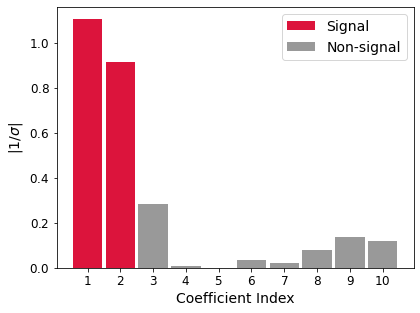

In [26]:
plt.bar(indexes[0:2], np.abs(bands)[0:2], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[2:], np.abs(bands)[2:], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks(indexes)
plt.legend()
plt.show()

##### Predictions on test

In [27]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=100)
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

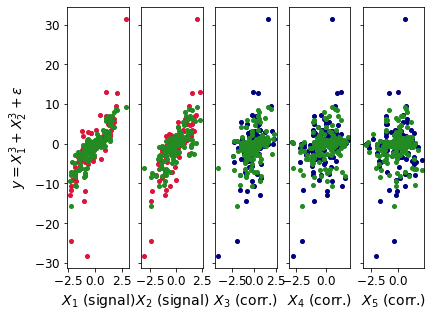

In [28]:
fig, ax = plt.subplots(ncols=5, sharey=True)
ax[0].plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax[0].plot(X_test[:, 0], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1^3 + X_2^3 + \epsilon$")
ax[1].plot(X_test[:, 1], y_test, 'o', markersize=4, color='crimson')
ax[1].plot(X_test[:, 1], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 5):
    ax[i].plot(X_test[:, i], y_test, 'o', markersize=4, color='navy')
    ax[i].plot(X_test[:, i], best_model(X_test).to('cpu').detach().numpy(), 'o', color='forestgreen', markersize=4)
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.show()

In [29]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

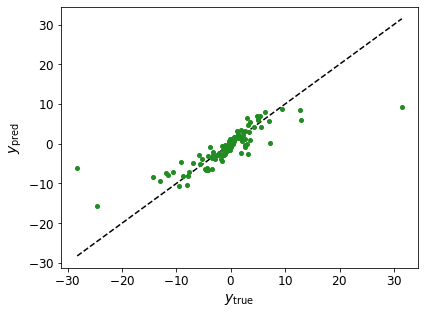

In [30]:
plt.plot(y_test, best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()